First few rows of the dataset:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #  

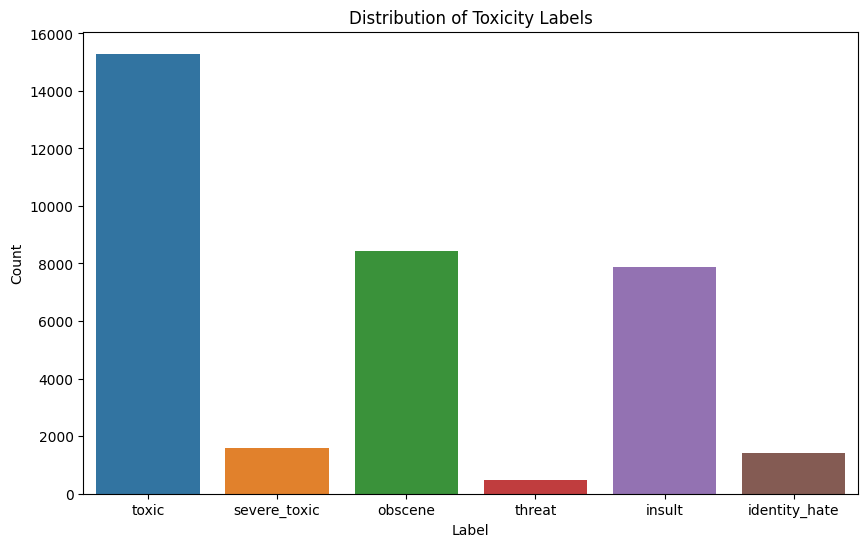


Distribution of Samples by Number of Toxicity Labels:
label_count
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


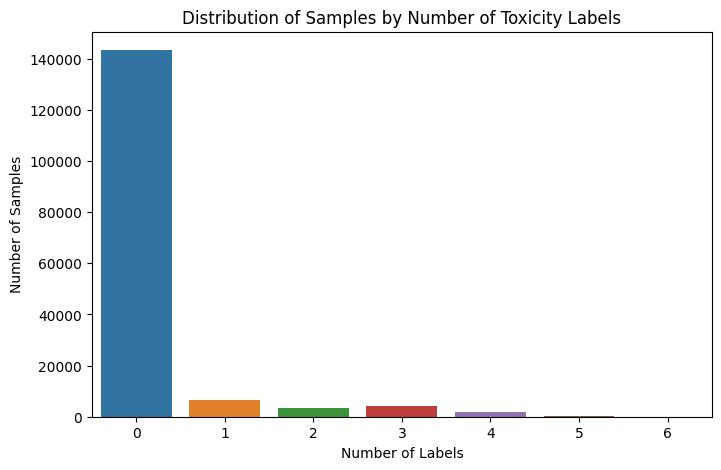


Text Length Statistics:
count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


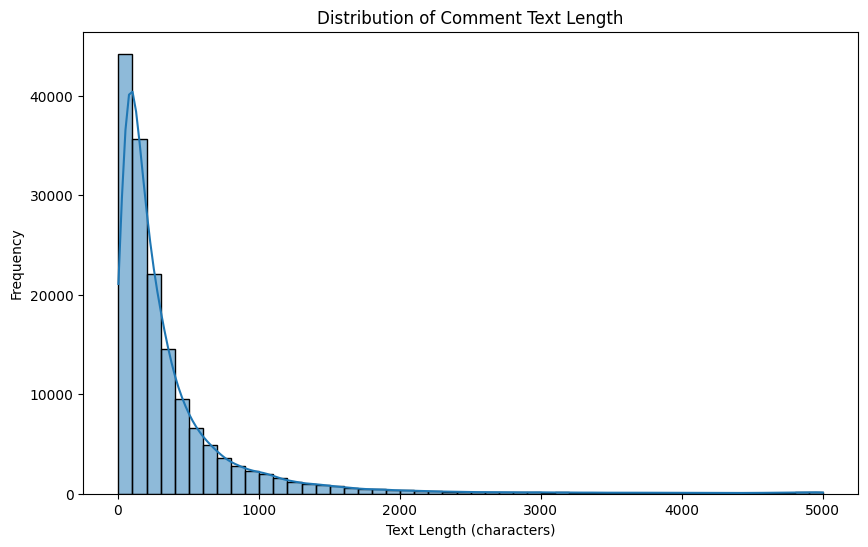

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/kaggle/input/abusive-language-detection-in-speech/Abusive Language Detection/train.csv')

# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

# Check dataset structure and statistics
print("\nDataset Structure:")
print(df.info())

print("\nSummary Statistics for Toxicity Labels:")
print(df.describe())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())

# Class distribution analysis
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
label_counts = df[label_columns].sum()
print("\nClass Distribution:")
print(label_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Toxicity Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Multi-label analysis: Count number of labels per sample
df['label_count'] = df[label_columns].sum(axis=1)
label_count_distribution = df['label_count'].value_counts().sort_index()
print("\nDistribution of Samples by Number of Toxicity Labels:")
print(label_count_distribution)

# Visualize multi-label distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=label_count_distribution.index, y=label_count_distribution.values)
plt.title('Distribution of Samples by Number of Toxicity Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Number of Samples')
plt.show()

# Text length analysis
df['text_length'] = df['comment_text'].apply(len)
print("\nText Length Statistics:")
print(df['text_length'].describe())

# Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Comment Text Length')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.show()


In [2]:
# Import necessary libraries
import pandas as pd
import torch
import re
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Load the training dataset
train_df = pd.read_csv('/kaggle/input/abusive-language-detection-in-speech/Abusive Language Detection/train.csv')

# Data Cleaning for training set
# Remove URLs
train_df['comment_text'] = train_df['comment_text'].replace(r'http\S+|www\S+|https\S+', '', regex=True)
# Remove special characters and numbers
train_df['comment_text'] = train_df['comment_text'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))
# Remove excessive whitespace
train_df['comment_text'] = train_df['comment_text'].replace(r'\s+', ' ', regex=True).str.strip()

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['comment_text'], train_df['toxic'], test_size=0.2, random_state=42)

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Custom Dataset class for RoBERTa
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",  # Padding to max length to avoid mismatch
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create train and validation datasets
train_dataset = ToxicCommentsDataset(X_train, y_train, tokenizer)
val_dataset = ToxicCommentsDataset(X_val, y_val, tokenizer)

# Use DataCollatorWithPadding for dynamic padding within each batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load the RoBERTa model for sequence classification
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",        # Evaluate only at the end of each epoch
    save_strategy="epoch",        # Save only at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",             # Disable W&B logging
    save_total_limit=1,           # Keep only the most recent checkpoint
    gradient_accumulation_steps=2 # Accumulate gradients over 2 steps for an effective batch size of 256
)

# Define metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Trainer with Early Stopping and data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Validation dataset used here for evaluation
    data_collator=data_collator,  # Use DataCollatorWithPadding to handle dynamic padding
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping if no improvement in 3 evals
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_result = trainer.evaluate()
print("Evaluation Result on Validation Set:", eval_result)

# (We will load and use test.csv for final predictions after training is completed)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.087400,0.084906,0.966097,0.825821,0.812738,0.839332
2,0.069200,0.080357,0.968228,0.836873,0.823101,0.851113


Evaluation Result on Validation Set: {'eval_loss': 0.08035706728696823, 'eval_accuracy': 0.9682281059063137, 'eval_f1': 0.8368725868725869, 'eval_precision': 0.8231012658227848, 'eval_recall': 0.8511125654450262, 'eval_runtime': 142.13, 'eval_samples_per_second': 224.548, 'eval_steps_per_second': 1.759, 'epoch': 2.0}


In [6]:
# Import necessary libraries
import pandas as pd
import torch
import re
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import Dataset

# Load and preprocess the test data
test_df = pd.read_csv('/kaggle/input/abusive-language-detection-in-speech/Abusive Language Detection/test.csv')

# Data Cleaning for test data (similar to training)
test_df['comment_text'] = test_df['comment_text'].replace(r'http\S+|www\S+|https\S+', '', regex=True)
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x))
test_df['comment_text'] = test_df['comment_text'].replace(r'\s+', ' ', regex=True).str.strip()

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define a custom dataset for the test set
class TestToxicCommentsDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Create the test dataset
test_dataset = TestToxicCommentsDataset(test_df['comment_text'], tokenizer)

# Load the trained model from the checkpoint directory
model = RobertaForSequenceClassification.from_pretrained('/kaggle/working/results/checkpoint-998')

# Define training arguments with W&B logging disabled
training_args = TrainingArguments(
    output_dir='./results',
    report_to="none"  # Disable W&B logging
)

# Initialize the Trainer with the loaded model and modified training arguments
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator
)

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Get the predicted labels (0 or 1) from the model's outputs
y_pred = predictions.predictions.argmax(axis=-1)

# Save the predictions to a CSV file with the comment ID and predicted label
output_df = pd.DataFrame({
    'id': test_df['id'],
    'predicted_toxic': y_pred
})

# Save to CSV
output_df.to_csv("/kaggle/working/test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Predictions saved to test_predictions.csv


In [ ]:
!zip -r /kaggle/working/training.zip  /kaggle/working/results/checkpoint-998